## World Wide Products Inc.
Shipping and delivering to a place near you
1. Set up a data science project structure in a new git repository in your GitHub account
2. Download the product demand data set from https://www.kaggle.com/felixzhao/productdemandforecasting
3. Load the data set into panda data frames
4. Formulate one or two ideas on how feature engineering would help the data set to establish additional value using exploratory data analysis
5. Build one or more forecasting models to determine the demand for a particular product using the other columns as features
6. Document your process and results
7. Commit your notebook, source code, visualizations and other supporting files to the git repository in GitHub

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt

import requests
from io import BytesIO
from zipfile import ZipFile
from sklearn import preprocessing

import warnings
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

from fbprophet import Prophet

In [2]:
productDemandDf = pd.read_csv('../data/productdemandforecasting.zip')
productDemandDf.tail(5)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
1048570,Product_1791,Whse_J,Category_006,2016/4/27,1000
1048571,Product_1974,Whse_J,Category_006,2016/4/27,1
1048572,Product_1787,Whse_J,Category_006,2016/4/28,2500
1048573,Product_0901,Whse_J,Category_023,2016/10/7,50
1048574,Product_0704,Whse_J,Category_001,2016/6/27,4


In [3]:
productDemandDf['Product_Code'].nunique()# seeing the number of unique products

2160

In [4]:
productDemandDf.dtypes

Product_Code        object
Warehouse           object
Product_Category    object
Date                object
Order_Demand        object
dtype: object

**Since the date feature is in generic object datatype, we have to convert it to datetime object type.**

In [5]:
productDemandDf['Date'] = pd.to_datetime(productDemandDf['Date']) 
productDemandDf.dtypes


Product_Code                object
Warehouse                   object
Product_Category            object
Date                datetime64[ns]
Order_Demand                object
dtype: object

**We have to convert order_demand to numeric type. So, we want to see whether all the values are convertible or not.**

In [6]:
productDemandDf[pd.to_numeric(productDemandDf['Order_Demand'], errors='coerce').isnull()].head(5)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
112290,Product_2169,Whse_A,Category_024,2012-08-09,(1)
112307,Product_2132,Whse_A,Category_009,2012-11-01,(24)
112308,Product_2144,Whse_A,Category_009,2012-11-01,(24)
112356,Product_2118,Whse_A,Category_009,2012-03-07,(50)
112357,Product_2120,Whse_A,Category_009,2012-03-07,(100)


**There are many values that are enclosed in parenthesis. So, we remove the parenthesis and convert string values to numeric.**

In [7]:
productDemandDf['Order_Demand'] = productDemandDf['Order_Demand'].apply(lambda x: x.replace('(','').replace(')',''))
productDemandDf['Order_Demand'] = pd.to_numeric(productDemandDf['Order_Demand'], errors='coerce')

In [8]:
productDemandDf.isnull().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

In [9]:
nullDates = productDemandDf[productDemandDf['Date'].isnull()]
nullDates['Product_Category'].unique()

array(['Category_019', 'Category_005', 'Category_028', 'Category_026',
       'Category_031', 'Category_006', 'Category_021'], dtype=object)

**There are number of rows where date is null. Since we are doing time series analysis, we cannot perform prediction on the section with null dates. So, we remove rows with null dates.**

In [10]:
cleanProductDemandDf = productDemandDf.dropna()
cleanProductDemandDf.head(5)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500


**We want to see the total number of products ordered monthly and also the number of unique product codes.**

In [11]:
monthlystats = cleanProductDemandDf.groupby(pd.Grouper(key='Date', freq="M")).agg({'Order_Demand':'sum','Product_Code':'nunique'}).reset_index()
monthlystats.head(5)

,Date,Order_Demand,Product_Code
0,2011-01-31,2,1
1,2011-02-28,0,0
2,2011-03-31,0,0
3,2011-04-30,0,0
4,2011-05-31,108,1


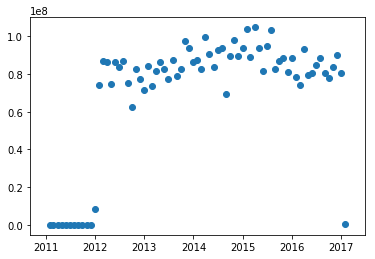

In [12]:
plt.scatter(monthlystats['Date'].values,monthlystats['Order_Demand'].values)
plt.show()

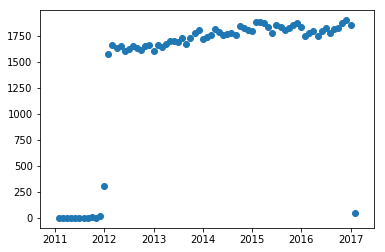

In [13]:
plt.scatter(monthlystats['Date'].values,monthlystats['Product_Code'].values)
plt.show()

**From both plots, we see that the data for demand and unique product codes seem to be incomplete in 2011 because it is not consistent with the remaining trend. So, we discard those data. Also the data for 2017 also seem to be incomplete and we discard this too.**

In [14]:
filteredProdDemand = productDemandDf[(productDemandDf.Date>pd.Timestamp('2011-12-31')) & \
                                     (productDemandDf.Date<pd.Timestamp('2017-1-1'))]

In [15]:
print(filteredProdDemand['Date'].min())
print(filteredProdDemand['Date'].max())

2012-01-01 00:00:00
2016-12-30 00:00:00


**Lets choose one product and apply SARIMAX to predict the demand.**

(751, 5)
        Order_Demand
count     751.000000
mean     4252.263648
std     11688.666941
min         0.000000
25%       150.000000
50%       500.000000
75%      3000.000000
max    152150.000000


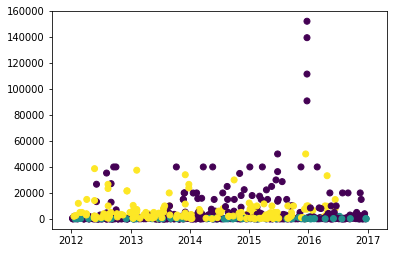

In [16]:
prod1000 = filteredProdDemand[filteredProdDemand['Product_Code']=='Product_1000'].copy() 
prod1000['Warehouse'] = prod1000['Warehouse'].astype('category')
plt.scatter(prod1000['Date'].values, prod1000['Order_Demand'].values,c=prod1000.Warehouse.cat.codes)
print(prod1000.shape)
print(prod1000.describe())

**There are multiple warehouses associated with a single product and the trend of the product demand varies with each warehouse as shown in the scatter plot. So, we will use SARIMAX model for individual warehouse.**

           median         mean           std
Warehouse                                   
Whse_A        500  4520.295983  13773.216544
Whse_J        150   228.915663    315.660407
Whse_S       2600  5314.615385   7640.039957


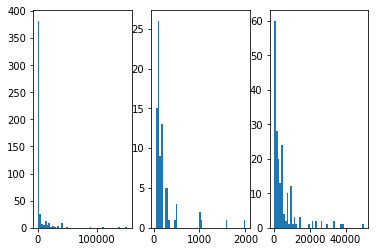

In [17]:
prod1000byWare = prod1000.groupby('Warehouse')['Order_Demand'].agg(median='median', mean='mean', std='std')
print(prod1000byWare)

fig,axes = plt.subplots(1,3)
for i, ware in enumerate(prod1000byWare.index.categories.values):
    axes[i].hist(prod1000[prod1000['Warehouse']==ware].Order_Demand, bins=50)
plt.show()

**The statistics and the histogram show that the data distribution is variant for different warehouse.**

**We have grouped the product demand of the selected product of selected warehouse by week since grouping by month gave few observation points.**

In [18]:
prod1000byWare1 = prod1000.groupby([pd.Grouper(key='Date', freq='W'),pd.Grouper('Warehouse')])['Order_Demand'].sum().reset_index()
prod1000byWare1.head(5)

,Date,Warehouse,Order_Demand
0,2012-01-08,Whse_S,NaN
1,2012-01-08,Whse_A,500.0
2,2012-01-08,Whse_J,NaN
3,2012-01-15,Whse_S,NaN
4,2012-01-15,Whse_A,600.0


**It is seen that the collection of data across the warehouse is not uniform since there are NaN values for some date intervals. We treat those NaN values as missing values and want our model to estimate those values.**

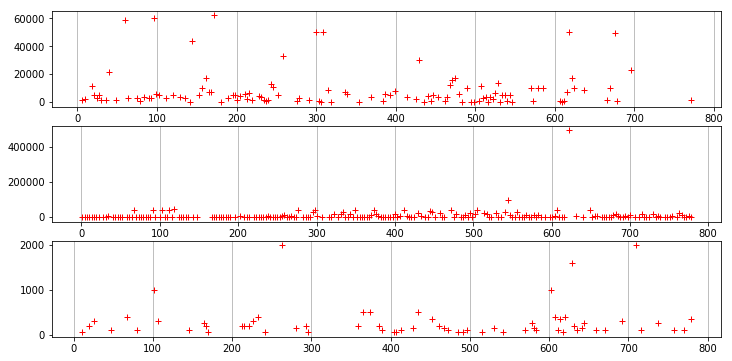

In [19]:
weeklystats1000 = []
fig, ax = plt.subplots(3,1,figsize=(12,6))
for i,ware in enumerate(prod1000byWare1.Warehouse.unique()):
    value=prod1000byWare1[prod1000byWare1['Warehouse']==ware]   
    weeklystats1000.insert(i,value)
    ax[i].xaxis.grid()
    ax[i].plot(weeklystats1000[i]['Order_Demand'], 'r+')
    

**SARIMAX has three hyperparameters in general p,d and q, where p is the number of lag observations included in the model, also called the lag order., d is the number of times that the raw observations are differenced, also called the degree of differencing and q is the size of the moving average window, also called the order of moving average.**

**We have kept d =1 and found out the other 2 hyperparameters finding the lowest value of AIC(Akaike Information Criteria).**

In [20]:
def getSARIMAXparam(data):
    
    aic = pd.DataFrame(np.zeros((6,6), dtype=float))
    warnings.simplefilter('ignore')
    # Iterate over all ARMA(p,q) models with p,q in [0,6]
    for p in range(6):
        for q in range(6):
            if p == 0 and q == 0:
                continue
                # Estimate the model with no missing datapoints
            mod = sm.tsa.statespace.SARIMAX(data, order=(p,1,q), enforce_invertibility=False)
            try:
                res = mod.fit(disp=False)
                aic.iloc[p,q] = res.aic
            except:
                aic.iloc[p,q] = np.nan
    return aic

In [21]:
dataRaw = []
aicList = []
for i, data in enumerate(weeklystats1000):
    dataRaw.insert(i, data['Order_Demand'].values)
    aicList.insert(i,getSARIMAXparam(dataRaw[i]))    

In [22]:
aicList[0]

,0,1,2,3,4,5
0,0.000000,2633.657399,2630.241042,2622.368165,2621.525833,2616.210194
1,2685.179832,2633.999675,2632.225366,2623.443016,2622.399205,2616.795211
2,2663.355404,2633.492909,2628.135899,2621.760563,2621.969848,2615.379613
3,2654.313313,2635.440875,2643.945552,NaN,2621.616145,2619.021890
4,2648.618846,2637.089205,NaN,NaN,2624.646387,NaN
5,2650.500039,2638.421837,NaN,NaN,NaN,NaN


In [23]:
aicList[1]

,0,1,2,3,4,5
0,0.000000,5427.580202,5051.153074,5049.009394,5030.773000,5016.869257
1,5452.986282,5074.568595,NaN,5049.410144,5010.032275,5007.392096
2,5330.005075,5028.420260,NaN,NaN,5008.831319,5008.851204
3,5301.361248,5024.201693,NaN,NaN,NaN,NaN
4,5286.524634,5025.264525,5007.829545,5010.325280,NaN,5009.522482
5,5278.955611,5026.047133,5008.392197,NaN,NaN,NaN


In [24]:
aicList[2]

,0,1,2,3,4,5
0,0.000000,988.353972,987.938604,989.938332,NaN,NaN
1,1021.966568,987.998529,990.143253,991.843408,NaN,NaN
2,1003.950096,NaN,990.955249,990.184212,NaN,NaN
3,999.779386,990.591839,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
hyperParam = [(2,1,5),(1,1,5),(1,1,1)]

**Now,we selected hyperparameters looking at the tables above and we are going to apply SARIMAX to data of all 3 warehouse.**

In [26]:
model = []
result = []
for i,param in enumerate(hyperParam):
    model.insert(i,sm.tsa.statespace.SARIMAX(dataRaw[i], order=param ,enforce_invertibility=False))
    result.insert(i,model[i].fit(disp=False))

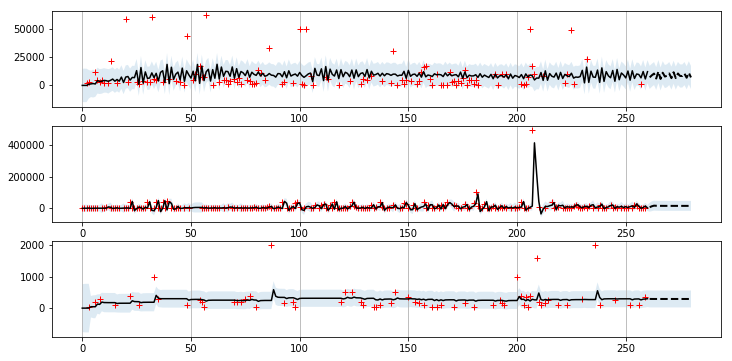

In [27]:
predict = []
idx = []
predict_ci = []
fig, ax = plt.subplots(3, 1, figsize=(12,6))
for i in range(len(model)):
    nforecast = 20
    predict.insert(i, result[i].get_prediction(end=model[i].nobs + nforecast))
    idx.insert(i, np.arange(len(predict[i].predicted_mean)))
    predict_ci.insert(i, predict[i].conf_int(alpha=0.5))
    ax[i].xaxis.grid()
    ax[i].plot(dataRaw[i], 'r+')
    ax[i].plot(idx[i][:-nforecast], predict[i].predicted_mean[:-nforecast], 'black')
    ax[i].plot(idx[i][-nforecast:], predict[i].predicted_mean[-nforecast:], 'k--', linestyle='--', linewidth=2)
    ax[i].fill_between(idx[i], predict_ci[i][:, 0], predict_ci[i][:, 1], alpha=0.15)
    

**The SARIMAX model we used considers the past values to predict the future. The non stationary data is made stationary using d=1. Since, there were many missing (NaN) values in the data, this model has tried to estimate those missing values seeing the recent past value. In the graph, there are some spaces without red '+' sign. Those spaces represent the missing values. As seen in the above graph, the values are reasonably fitted by the model, if the data trend is almost stationary. However, the future values predicted are stationary around the mean.**

In [28]:
size = int(len(dataRaw[1]) * 0.75)
train, test = dataRaw[1][0:size], dataRaw[1][size:len(dataRaw[1])]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = sm.tsa.statespace.SARIMAX(history, order=(1,1,5))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))


Test MSE: 8013219857.711


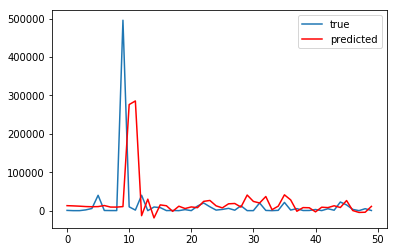

In [29]:
notNan =  ~np.isnan(test)
error = mean_squared_error(test[notNan], np.array(predictions)[notNan])
print('Test MSE: %.3f' % error)
# plot
plt.plot(test[notNan],label='true')
plt.plot(np.array(predictions)[notNan], color='red',label = 'predicted')
plt.legend()
plt.show()

**In the above graph, although the mean square error is very high, the predicted value has tried to follow the true value. If the data distribution is stationary, this model seems work well. The model suffers, if the data has fluctuation.**


### **Prophet**
**Now we will use prophet for all 3 cases above.**

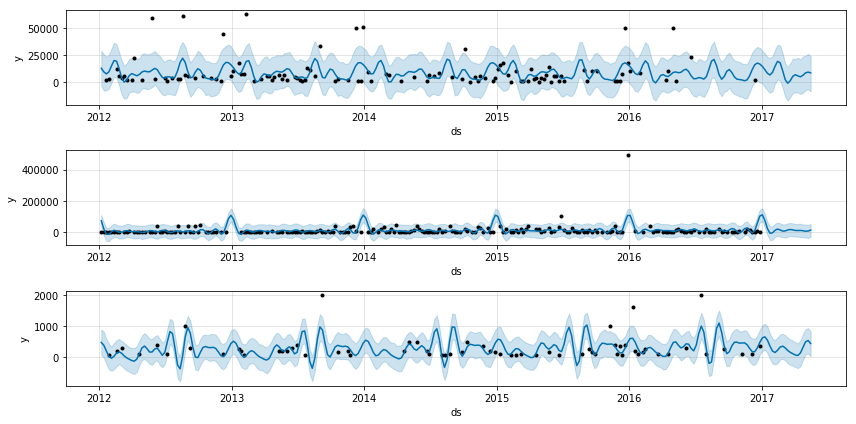

In [31]:
forecast = []
future = []
df = []
prophetModel = []
fig, ax = plt.subplots(3, 1, figsize=(12,6))
for i in range(len(weeklystats1000)):
    df.insert(i,weeklystats1000[i][['Date','Order_Demand']])  
    df[i].columns = ['ds','y']
    prophetModel.insert(i,Prophet(weekly_seasonality=True, daily_seasonality=False))    
    prophetModel[i].fit(df[i])
    future.insert(i, prophetModel[i].make_future_dataframe(periods=20,freq='W'))
    forecast.insert(i, prophetModel[i].predict(future[i]))
    forecast[i][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    prophetModel[i].plot(forecast[i],ax=ax[i])
plt.show() 

**As seen from the above graphs, prophet is seen to maintain the periodocity of the trend. In comparison to SARIMAX, prophet predicts the future data and fills the missing values maintaining the periodocity whereas SARIMAX predicts the future data around the mean and fills the missing values looking at the recent past trend.**

In [32]:
size = int(len(df[1]) * 0.75)
train = df[1][0:size].reset_index()
test = df[1][size:].reset_index()
predictions = list()
for t in range(len(test)):
    model = Prophet(weekly_seasonality=True,daily_seasonality=False)
    model.fit(train)
    future = model.make_future_dataframe(periods=1,freq='W')
    output = model.predict(future)
    yhat = output['yhat'].values[0]
    predictions.append(yhat)
    ds = test['ds'].iloc[t]
    #print(type(ds))
    obs = test['y'].iloc[t]
    #print(obs)
    train.loc[len(train)] = test.iloc[t].values
   # print('predicted=%f, expected=%f' % (yhat, obs))


Test MSE: 9916877484.232


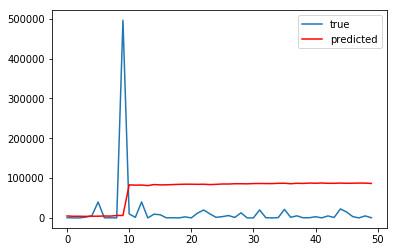

In [33]:
notNan =  ~np.isnan(test['y'].values)
error = mean_squared_error(test['y'].values[notNan], np.array(predictions)[notNan])
print('Test MSE: %.3f' % error)
# plot
plt.plot(test['y'].values[notNan],label='true')
plt.plot(np.array(predictions)[notNan], color='red',label = 'predicted')
plt.legend()
plt.show()

**We want to see how prophet predicts the value for the next timestamp. The predicted values are affected by outliers in prophet whereas in SARIMAX, prediction is quicky recovered from the outliers.**

In [34]:
train = df[1][0:size].reset_index()
model = Prophet(weekly_seasonality=True, daily_seasonality=False)
model.fit(train)
future = model.make_future_dataframe(periods=len(test),freq='W')
output = model.predict(future)
yhat = output['yhat'].values[-len(test):]

Test MSE: 4913383141.147


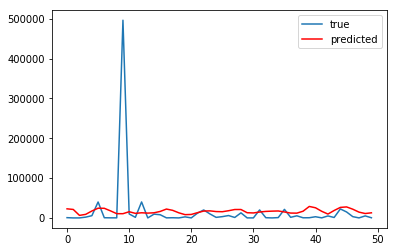

In [35]:
notNan =  ~np.isnan(test['y'].values)
error = mean_squared_error(test['y'].values[notNan], yhat[notNan])
print('Test MSE: %.3f' % error)
# plot
plt.plot(test['y'].values[notNan],label='true')
plt.plot(yhat[notNan], color='red',label = 'predicted')
plt.legend()
plt.show()

**In the above graph, we see the 25% new predictions after training with 75% timeseries data. The prediction seems to match the original data except for the outliers and reduces the mean square error. It can be observed that prophet is able to predict the long term values more precisely than the SARIMAX. However. short term prediction is precise for SARIMAX rather than the prophet.**